### 점프 확산 모형 

10장에서 첯럼 오일러 이산화를 해야 한다. 수식 확인은 10장에서! 

In [20]:
#
# DX Library Simulation
# jump_diffusion.py
#

import numpy as np
import pandas as pd

from sn_random_numbers import sn_random_numbers
from simulation_class import simulation_class

class jump_diffusion(simulation_class):
    '''
    점프 확산 모형에 따른 시뮬레이션 경로 생성
    
    속성
    ----
    name : string
        객체 이름
    mar_env : instance of market_environment
        시뮬레이션에 필요한 시장 환경
    corr : Boolean
        상관관계 있으면 True
    
    method
    ----
    update : 
        파라미터 갱신
    generate_paths :
        주어진 시장환경에 따른 몬테카를로 경로 변환
    '''
    
    def __init__(self,name,mar_env,corr=False):
        super(jump_diffusion,self).__init__(name,mar_env,corr)
        try:
            #추가 파라미터 필요
            self.lamb = mar_env.get_constant('lambda')
            self.mu = mar_env.get_constant('mu')
            self.delt = mar_env.get_constant('delta')
        except :
            print('Error parsing market environment')
            
    def update(self,initial_value= None, volatility = None, lamb = None,
              mu = None, delta = None, final_date = None):
        if initial_value is not None:
            self.initial_value =initial_valuee
        if volatility is not None :
            self.volatility = volatility
        if lamb is not None : 
            self.lamb = lamb
        if mu is not None:
            self.mu = mu
        if delta is not None :
            self.delt = delta
        if final_date is not None :
            self.final_date = final_date
        self.instrument_values = None

    def generate_time_grid(self):
        start = self.pricing_date
        end = self.final_date
            # pandas date_range function
            # freq = e.g. 'B' for Business Day,
            # 'W' for Weekly, 'M' for Monthly
        time_grid = pd.date_range(start=start, end=end,
                                  freq=self.frequency).to_pydatetime()
        time_grid = list(time_grid)
        # enhance time_grid by start, end, and special_dates
        if start not in time_grid:
            time_grid.insert(0, start)
            # insert start date if not in list
        if end not in time_grid:
            time_grid.append(end)
            # insert end date if not in list
        if len(self.special_dates) > 0:
            # add all special dates
            time_grid.extend(self.special_dates)
            # delete duplicates
            time_grid = list(set(time_grid))
            # sort list
            time_grid.sort()
        self.time_grid = np.array(time_grid)
        
    def generate_paths(self, fixed_seed = False, day_count = 365.):
        if self.time_grid is None:
            self.generate_time_grid()
        M = len(self.time_grid)
        I = self.paths
        paths = np.zeros((M,I))
        paths[0] = self.initial_value
        if self.correlated is False:
            sn1 = sn_random_numbers((1,M,I),fixed_seed= fixed_seed)
        else :
            #상관관계 있을 시
            sn1 = self.random_numbers
        #표준정규분포 난수생성
        sn2 = sn_random_numbers((1,M,I),fixed_seed = fixed_seed)
        rj = self.lamb*(np.exp(self.mu + 0.5*self.delt**2)-1)
        
        short_rate = self.discount_curve.short_rate
        for t in range(1,len(self.time_grid)):
            if self.correlated is False :
                ran = sn1[t]
            else:
                ran = np.dot(self.cholesky_matrix, sn1[:,t,:])
                ran = ran[self.rn_set]
            dt = (self.time_grid[t] - self.time_grid[t-1]).days/day_count
                #1년 기준 비율 표현
            poi = np.random.poisson(self.lamb*dt,I)
            paths[t] = paths[t-1]*(np.exp((short_rate-rj -0.5*self.volatility**2)*dt+self.volatility*np.sqrt(dt)*ran)
                                  +(np.exp(self.mu+self.delt*sn2[t])-1)*poi)
            self.instrument_values = paths

**EX**

In [21]:
from market_environment import *
from dx_frame import *
import datetime as dt
from geometric_brownian_motion import geometric_brownian_motion

In [22]:
me_jd = market_environment('me_jd',dt.datetime(2015,1,1))

In [23]:
me_jd.add_constant('lambda',0.3)
me_jd.add_constant('mu',-0.75)
me_jd.add_constant('delta',0.1)

In [24]:
#16-3에서 사용한 me_gbm
me_gbm = market_environment('me_gbm',dt.datetime(2015,1,1))

me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2)
me_gbm.add_constant('final_date', dt.datetime(2015, 12, 31))
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('frequency', 'M')
# monthly frequency (respective month end)
me_gbm.add_constant('paths', 10000)

csr = constant_short_rate('csr',0.05)

me_gbm.add_curve('discount_curve',csr)

gbm = geometric_brownian_motion('gbm',me_gbm)

In [25]:
me_jd.add_environment(me_gbm)

In [26]:
#from jump_diffusion import jump_diffusion
jd = jump_diffusion('jd',me_jd)

In [27]:
%time paths_3 = jd.get_instrument_values()

Wall time: 32.9 ms


In [28]:
jd.update(lamb= 0.9)

In [29]:
%time paths_4 = jd.get_instrument_values()

Wall time: 39.9 ms


In [34]:
#16-3에서 사용
gbm = geometric_brownian_motion('gbm',me_gbm)
gbm.generate_time_grid()
gbm.update(volatility = 0.5)

(array([16436., 16495., 16556., 16617., 16679., 16740., 16801.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

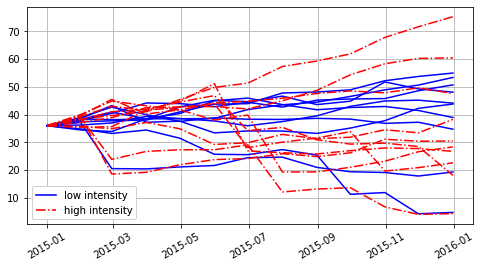

In [35]:
#높은 강도와 낮은 강도 (점프) 비교
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (8,4))
p1 = plt.plot(gbm.time_grid,paths_3[:,:10],'b')
p2 = plt.plot(gbm.time_grid,paths_4[:,:10], 'r-.')
plt.grid(True)
l1 = plt.legend([p1[0],p2[0]],['low intensity','high intensity'],loc = 3)
plt.gca().add_artist(l1)
plt.xticks(rotation = 30)